## RBF vs Nystroem kernel approximation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn import svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
# from sklearn.decomposition import PCA
from sklearn import datasets

In [4]:
from keras.datasets import mnist

Using TensorFlow backend.


## Define classifiers

In [5]:
# SVM classifiers
gamma = 0.5
kernel_svm = svm.SVC(kernel='rbf', gamma=gamma)
linear_svm = svm.SVC(kernel='linear')

In [6]:
# the two methods
random_fourier = RBFSampler(gamma=gamma, random_state=1)
nystroem = Nystroem(gamma=gamma, random_state=1)

# pipelines for kernel approxixmations
fourier_svm = pipeline.Pipeline([("feature_map", random_fourier),("svm", linear_svm)])
nystroem_svm = pipeline.Pipeline([("feature_map", nystroem),("svm", linear_svm)])

## Fitting functions

In [7]:
# fit and predict linear and kernel SVMs

def kernel(train_data, train_labels, test_data, test_labels):
    start = time()
    kernel_svm.fit(train_data, train_labels)
    kernel_svm_score = kernel_svm.score(test_data,test_labels)
    kernel_svm_time = time() - start
    return({'score':kernel_svm_score, 'time':kernel_svm_time})

def linear(train_data, train_labels, test_data, test_labels):
    start = time()
    linear_svm.fit(train_data, train_labels)
    linear_svm_score = linear_svm.score(test_data, test_labels)
    linear_svm_time = time() - start
    return ({'score':linear_svm_score, 'time':linear_svm_time})

In [19]:
# number of random samples
def samples(train_data):
    samples = len(train_data)//20 * np.arange(1,10)
    return(samples)

In [21]:
def nystroem(train_data, train_labels, test_data, test_labels):
    
    nystroem_scores = []
    nystroem_times = []
    sample_sizes = samples(train_data)

    for D in sample_sizes:
        # set the number of samples
        nystroem_svm.set_params(feature_map__n_components=D)

        start = time()
        nystroem_svm.fit(train_data, train_labels)
        nystroem_times.append(time() - start)

        nystroem_score = nystroem_svm.score(test_data, test_labels)
        nystroem_scores.append(nystroem_score)
    
    return({'scores':nystroem_scores, 'times':nystroem_times})

In [22]:
def fourier(train_data, train_labels, test_data, test_labels):

    fourier_scores = []
    fourier_times = []
    sample_sizes = samples(train_data)

    for D in sample_sizes:
        fourier_svm.set_params(feature_map__n_components=D)

        start = time()
        fourier_svm.fit(train_data, train_labels)
        fourier_times.append(time() - start)

        fourier_score = fourier_svm.score(test_data, test_labels)
        fourier_scores.append(fourier_score)

    return({'scores':fourier_scores, 'times':fourier_times})

In [11]:
def fit_all(train_data, train_labels, test_data, test_labels):
    
    kernel_out = kernel(train_data, train_labels, test_data, test_labels)
    linear_out = linear(train_data, train_labels, test_data, test_labels)
    nystroem_out = nystroem(train_data, train_labels, test_data, test_labels)
    fourier_out = fourier(train_data, train_labels, test_data, test_labels)
    
    return({'kernel':kernel_out, 'linear':linear_out, 'nystroem':nystroem_out, 'fourier':fourier_out})

## plot

In [26]:
# takes a fit_all argument
def plot(fit):
    
    kernel = fit['kernel']
    linear = fit['linear']
    nystroem = fit['nystroem']
    fourier = fit['fourier']
    
    kernel_svm_score = kernel['score']
    linear_svm_score = linear['score']
    nystroem_scores = nystroem['scores']
    fourier_scores = fourier['scores']
    
    kernel_svm_time = kernel['time']
    linear_svm_time = linear['time']
    nystroem_times = nystroem['times']
    fourier_times = fourier['times']
    
    sample_sizes = samples(train_data)
    
    # plot the results
    plt.figure(figsize=(8, 8))

    accuracy = plt.subplot(211)
    # second y axis for timings
    timescale = plt.subplot(212)

    accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
    timescale.plot(sample_sizes, nystroem_times, '--',
                   label='Nystroem approx. kernel')

    accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
    timescale.plot(sample_sizes, fourier_times, '--',
                   label='Fourier approx. kernel')

    # horizontal lines for exact rbf and linear kernels:
    accuracy.plot([sample_sizes[0], sample_sizes[-1]],
                  [linear_svm_score, linear_svm_score], label="linear svm")
    timescale.plot([sample_sizes[0], sample_sizes[-1]],
                   [linear_svm_time, linear_svm_time], '--', label='linear svm')

    accuracy.plot([sample_sizes[0], sample_sizes[-1]],
                  [kernel_svm_score, kernel_svm_score], label="rbf svm")
    timescale.plot([sample_sizes[0], sample_sizes[-1]],
                   [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

    # vertical line for dataset dimensionality = 64
    # accuracy.plot([64, 64], [0.7, 1], label="n_features")

    # legends and labels
    accuracy.set_title("Classification accuracy")
    timescale.set_title("Training times")
    accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
    # accuracy.set_xticks(())
    accuracy.set_ylim(np.min(fourier_scores), 1)
    timescale.set_xlabel("Sampling steps = transformed feature dimension")
    accuracy.set_ylabel("Classification accuracy")
    timescale.set_ylabel("Training time in seconds")
    accuracy.legend(loc='best')
    timescale.legend(loc='best')

    plt.show()

## Small MNIST

In [13]:
# load digits dataset

digits = datasets.load_digits(n_class=9)
# digits = datasets.fetch_mldata("MNIST original")

print(digits.data.shape)
# plt.matshow(digits.images[0])
# it contains 1617 images of digits. 
# Each image is represented by an 8x8 matrix.

(1617, 64)


In [14]:
n_samples = len(digits.data)
# normalize data: here pixels have values between 0 and 16

data = digits.data / 16.
# each image is a row vector with 64 entries.
# we take the mean of each column, which gives 64 means (one over each component of the image)
mean = data.mean(axis=0)
len(mean)

# averaging
data -= mean

In [15]:
# train-test half split 
train_data, train_labels = (data[:n_samples // 2], digits.target[:n_samples // 2])
test_data, test_labels = (data[n_samples // 2:], digits.target[n_samples // 2:])

In [24]:
small_mnist_fit = fit_all(train_data, train_labels, test_data, test_labels)

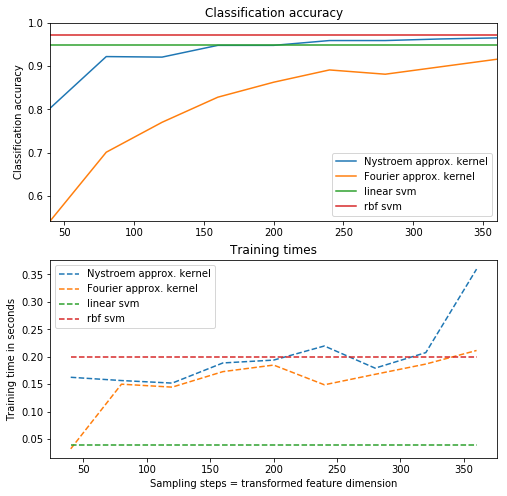

In [27]:
plot(small_mnist_fit)

## MNIST original

Following this: https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/


In [6]:

(X_train, y_train), (X_test, y_test) = mnist.load_data()
digits = X_train

print(X_train.shape)

# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

print(X_train.shape)
# normalize from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# now to -1 - 1
train_mean = X_train.mean(axis=0)
test_mean = X_test.mean(axis=0)

X_train -= train_mean
X_test -= test_mean


# not taking the whole dataset
X_train = X_train[:8000]
y_train = y_train[:8000]
X_test = X_test[:1000]
y_test = y_test[:1000]

print(X_train.shape[0],X_test.shape[0])

(60000, 28, 28)
(60000, 784)


In [27]:
# fit and predict linear and kernel SVMs
start = time()
kernel_svm.fit(X_train, y_train)
kernel_svm_score = kernel_svm.score(X_test,y_test)
kernel_svm_time = time() - start

start = time()
linear_svm.fit(X_train, y_train)
linear_svm_score = linear_svm.score(X_test,y_test)
linear_svm_time = time() - start

with open('mnist_kernel.txt', 'w') as saveFile:
    saveFile.write(kernel_svm_time + "\n")
    saveFile.write(kernel_svm_score + "\n")

with open('mnist_linear.txt', 'w') as saveFile:
    saveFile.write(linear_svm_time + "\n")
    saveFile.write(linear_svm_score + "\n")

In [8]:
# number of random samples
sample_sizes = 60 * np.arange(1,10)
sample_sizes

array([ 60, 120, 180, 240, 300, 360, 420, 480, 540])

In [9]:
nystroem_scores = []
nystroem_times = []

for D in sample_sizes:
    # set the number of samples
    nystroem_svm.set_params(feature_map__n_components=D)

    start = time()
    nystroem_svm.fit(X_train, y_train)
    nystroem_times.append(time() - start)

    nystroem_score = nystroem_svm.score(X_test, y_test)
    nystroem_scores.append(nystroem_score)
    
nystroem_scores

[0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0.126]

In [ ]:
with open('mnist_nystroem.txt', 'w') as saveFile:
    #.write() does not automatically add a newline, like print does
    saveFile.write(nystroem_scores + "\n")

In [ ]:
fourier_scores = []
fourier_times = []

for D in sample_sizes:
    fourier_svm.set_params(feature_map__n_components=D)

    start = time()
    fourier_svm.fit(X_train, y_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_svm.score(X_test, y_test)
    fourier_scores.append(fourier_score)

fourier_scores

with open('mnist_fourier.txt', 'w') as saveFile:
    #.write() does not automatically add a newline, like print does
    saveFile.write(fourier_scores + "\n")

In [ ]:
# plot the results
plt.figure(figsize=(8, 8))
accuracy = plt.subplot(211)
# second y axis for timings
timescale = plt.subplot(212)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
# accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')

plt.show()

## Adult dataset

In [13]:
adult = pd.read_csv(
    "datasets/adult.data.txt",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")
adult.tail()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [16]:
from sklearn.preprocessing import OneHotEncoder

adult_labels = OneHotEncoder(adult)

TypeError: 'OneHotEncoder' object is not iterable